# Data Preparation and Preprocessing
In this notebook, we prepare the dataset, found in "sel_dataset.csv".

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

### Data Augmentation - Superimpose Dataset
Superimposition is primarily used to augment the dataset by creating synthetic examples. This helps in scenarios where the model needs more data to learn from, especially to generalize well across different operational conditions that may not be sufficiently covered by the existing data. In this case, there is a limited amount of data pertainng to SELs. Hence, the dataset will be augmented by superimposing a dataset containing voltage readings of a circuit during normal operation (no SELs). After superimposing, the following are the expected changes:
- Higher Signal Levels: The combined signal will have higher peaks as you're summing the values from both datasets.
- Increased Noise: The noise level might also appear to be higher, especially if the no_sel_dataset contains a lot of variabilities.

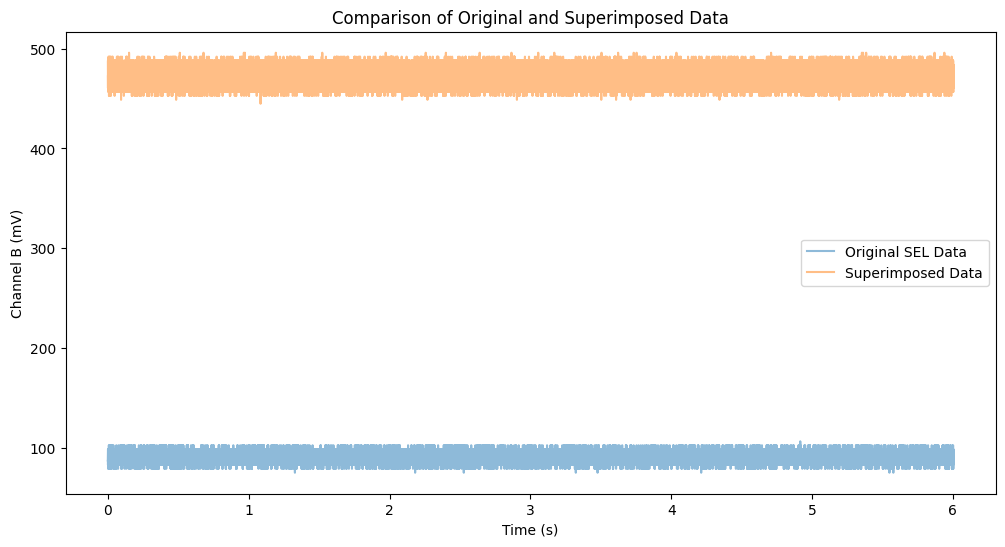

In [12]:
# Load datasets
sel_data = pd.read_csv('sel_dataset.csv')
no_sel_data = pd.read_csv('no_sel_dataset.csv')

# Convert no_sel_dataset voltage from volts to millivolts
no_sel_data['Channel B (mV)'] = no_sel_data['Channel B (V)'] * 1000

# Assume time steps are aligned; superimpose 'Channel B (mV)' from both datasets
# Make sure both dataframes have the same length; trim if necessary
min_length = min(len(sel_data), len(no_sel_data))
superimposed_data = sel_data.loc[:min_length-1].copy()
superimposed_data['Channel B (mV)'] += no_sel_data.loc[:min_length-1, 'Channel B (mV)']

# Save the superimposed dataset
superimposed_data.to_csv('superimposed_dataset.csv', index=False)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(sel_data['Time (s)'][:1000000], sel_data['Channel B (mV)'][:1000000], label='Original SEL Data', alpha=0.5)
plt.plot(superimposed_data['Time (s)'][:1000000], superimposed_data['Channel B (mV)'][:1000000], label='Superimposed Data', alpha=0.5)
plt.title('Comparison of Original and Superimposed Data')
plt.xlabel('Time (s)')
plt.ylabel('Channel B (mV)')
plt.legend()
plt.show()


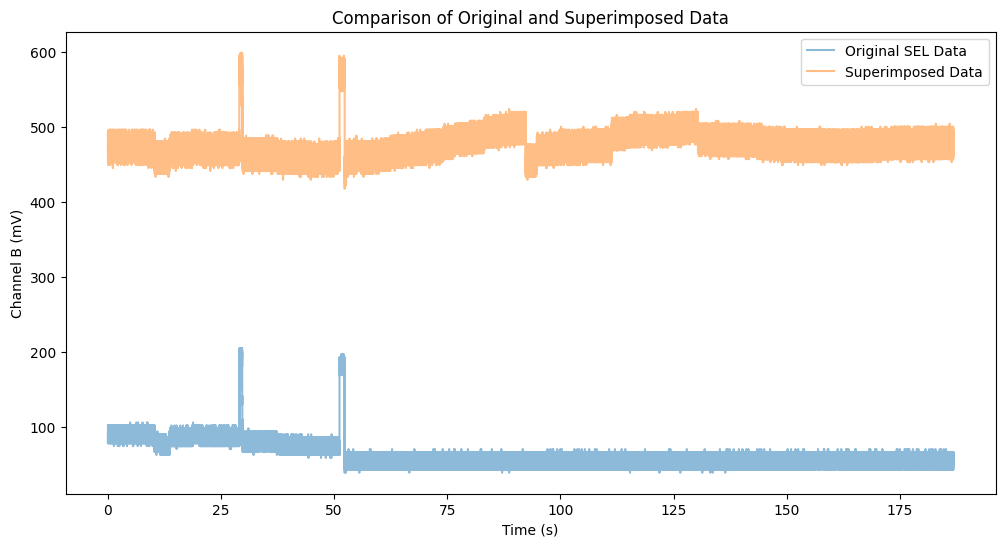

In [13]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(sel_data['Time (s)'], sel_data['Channel B (mV)'], label='Original SEL Data', alpha=0.5)
plt.plot(superimposed_data['Time (s)'], superimposed_data['Channel B (mV)'], label='Superimposed Data', alpha=0.5)
plt.title('Comparison of Original and Superimposed Data')
plt.xlabel('Time (s)')
plt.ylabel('Channel B (mV)')
plt.legend()
plt.show()

### Finding Relevant Regions in the Dataset (regions around SEL events)
Here, we take the 100000 records before and after each SEL occurence, which leads to 400000 records.

In [6]:
# Load the dataset
data = pd.read_csv('superimposed_dataset.csv')

# Identify the first instance of SEL
first_sel_1_index = data[data['SEL'] == 1].index[0]

# Identify the second instance of SEL at given time
second_sel_1_index = data[data['Time (s)'] >= 51.17749841].index[0]

# Calculate the window limits for both instances
start_index_1 = max(0, first_sel_1_index - 100000)
end_index_1 = min(len(data), first_sel_1_index + 100000)

start_index_2 = max(0, second_sel_1_index - 100000)
end_index_2 = min(len(data), second_sel_1_index + 100000)

# Extract subsets for both instances
subset_1 = data.loc[start_index_1:end_index_1]
subset_2 = data.loc[start_index_2:end_index_2]

### Data Augmentation and Expansion - Additive and Multiplicative
Augment the dataset to allow for more variability.

In [9]:
# Create augmented subsets 3 and 4 (additive increase)
subset_3 = subset_1.copy()
subset_3['Channel B (mV)'] = subset_3['Channel B (mV)'] + 100
subset_4 = subset_2.copy()
subset_4['Channel B (mV)'] = subset_4['Channel B (mV)'] + 100

# Create augmented subsets 5 and 6 (multiplicative increase)
subset_5 = subset_1.copy()
subset_5['Channel B (mV)'] = subset_5['Channel B (mV)'] * 3
subset_6 = subset_2.copy()
subset_6['Channel B (mV)'] = subset_6['Channel B (mV)'] * 3

In [10]:
def extract_features(subset):
    # Define window width and step size
    window_width = 50  # 50 samples per window
    step_size = 12  # quarter of the window width
    
    # Initialize an empty list to store the feature vectors
    feature_vectors = []
    
    # Slide the window across the dataset
    for start in range(0, len(subset) - window_width + 1, step_size):
        end = start + window_width
        window = subset.iloc[start:end]
        
        # Extract features
        min_val = window['Channel B (mV)'].min()
        max_val = window['Channel B (mV)'].max()
        range_val = max_val - min_val
        mean_val = window['Channel B (mV)'].mean()
        std_val = window['Channel B (mV)'].std()
        var_val = window['Channel B (mV)'].var()
        median_val = window['Channel B (mV)'].median()
        mad_val = np.median(np.abs(window['Channel B (mV)'] - median_val))
        kurtosis_val = kurtosis(window['Channel B (mV)'], fisher=False)
        skewness_val = window['Channel B (mV)'].skew()
        
        # Determine the label for the current window
        label = 1 if window['SEL'].sum() > 0 else 0  # if any SEL in the window is 1, label the window as 1
        
        # Append the feature vector to the list
        feature_vectors.append([min_val, max_val, range_val, mean_val, std_val, var_val, mad_val, kurtosis_val, skewness_val, label])
    
    return feature_vectors

# Extract features for both subsets
features_1 = extract_features(subset_1)
features_2 = extract_features(subset_2)
features_3 = extract_features(subset_3)
features_4 = extract_features(subset_4)
features_5 = extract_features(subset_5)
features_6 = extract_features(subset_6)

# Convert the feature vectors to DataFrames
features_df_1 = pd.DataFrame(features_1, columns=['Min', 'Max', 'Range', 'Mean', 'Std', 'Var', 'Mad', 'Kstatistic', 'Skewness', 'Label'])
features_df_2 = pd.DataFrame(features_2, columns=['Min', 'Max', 'Range', 'Mean', 'Std', 'Var', 'Mad', 'Kstatistic', 'Skewness', 'Label'])
features_df_3 = pd.DataFrame(features_3, columns=['Min', 'Max', 'Range', 'Mean', 'Std', 'Var', 'Mad', 'Kstatistic', 'Skewness', 'Label'])
features_df_4 = pd.DataFrame(features_4, columns=['Min', 'Max', 'Range', 'Mean', 'Std', 'Var', 'Mad', 'Kstatistic', 'Skewness', 'Label'])
features_df_5 = pd.DataFrame(features_5, columns=['Min', 'Max', 'Range', 'Mean', 'Std', 'Var', 'Mad', 'Kstatistic', 'Skewness', 'Label'])
features_df_6 = pd.DataFrame(features_6, columns=['Min', 'Max', 'Range', 'Mean', 'Std', 'Var', 'Mad', 'Kstatistic', 'Skewness', 'Label'])

# Combine the feature DataFrames into one DataFrame
combined_features_df = pd.concat([features_df_1, features_df_2, features_df_3, features_df_4, features_df_5, features_df_6]).reset_index(drop=True)

# Save the combined feature vectors to a new CSV file
combined_features_df.to_csv('combined_feature_vectors.csv', index=False)